In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os

In [2]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [3]:
!pwd
data_folder_path = './data/'
df = pd.read_csv(data_folder_path + 'train.csv')
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

/mnt/a/OneDrive/UNSW/COMP9444/9444_toxic_comment_classification


In [4]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)

In [5]:
df[0:20]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war It'...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can do that later on, if no-one else ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero Any chance you remember ...",0,0,0,0,0,0
5,00025465d4725e87,""" Congratulations from me as well, use the to...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [7]:
X_train = df['comment_text']
X_labels = df[classes]

In [8]:
X_train = X_train.values.tolist()

X_labels = X_labels.values.tolist()
X_labels[6]

[1, 1, 1, 0, 1, 0]

In [9]:
from torchtext.vocab import GloVe, vocab

# unk_token = "<pad>"
unk_index = 0
glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


1193514
torch.Size([1193515, 200])


In [10]:
from torch.utils.data import IterableDataset

tokenizer = get_tokenizer("basic_english")


class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]

        diff = self.max_len - len(tokens)
        # print('diff',diff)
        if diff > 0:
            tokens += [self.pad_token] * diff
            # print('tokens',to
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [11]:
MAX_LEN = 100
train_dataset = MyDataset(df, MAX_LEN)

In [12]:
for data in train_dataset:
    print(data['text'])
    print(data['labels'])
    print(data['indices'])
    break

['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', '?', 'they', 'weren', "'", 't', 'vandalisms', ',', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'i', "'", 'm', 'retired', 'now', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tensor([0., 0., 0., 0., 0., 0.])
tensor([ 19877,    164,     13,  34435,    425,   1477,     29,   7641,   8883,
         18462,    830,    377, 3

In [13]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = False, is_batch = True):
        super(TextClassificationModel, self).__init__()
        self.is_batch = is_batch
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers= 1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):

        embedded = self.embedding(indices)

        lstm_out, (hidden, cell) = self.lstm(embedded)

        lstm_out = torch.relu(lstm_out[:,-1,:])

        out = self.fc(lstm_out)

        out = self.sigmoid(out)

        # preds = torch.where(out > 0.5, torch.ones_like(out), torch.zeros_like(out))

        return out

In [14]:
## OK let's try to run this model to see if dimensions are correct!
#glove_model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64, is_batch=False)

#for idx, data in enumerate(train_dataset):
#    print("---------------------------------")
#    print('next example id ', idx)
#    print("---------------------------------")
#    # example_text = data['text']
#    text_input = data['indices']
    # print('tensor_shape: ', text_input.shape)
#    model_output = glove_model(text_input)
    # fwd = glove_model.forward(text_input)
    # print('embedding_bag: ',  fwd.shape)
    # print('output_shape: ', model_output.shape)
#    print('output: ', model_output)

    #if idx == 2:
#    break

In [25]:
from torch.utils.data import DataLoader


BATCH_SIZE = 1024

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
torch.set_grad_enabled(True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCEWithLogitsLoss()


cuda:0
Epoch: 0 Batch: 0 Loss: 0.9553380012512207
Epoch: 0 Batch: 100 Loss: 0.9534780979156494
Epoch: 0 Loss: 0.9526884452654765 Accuracy: 0.7128958106040955


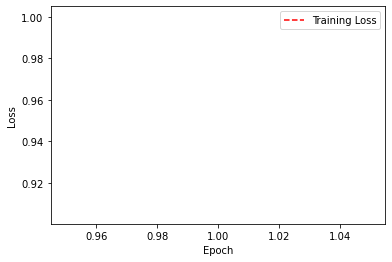

Epoch: 1 Batch: 0 Loss: 0.9497973918914795
Epoch: 1 Batch: 100 Loss: 0.9469302892684937
Epoch: 1 Loss: 0.9487920556312952 Accuracy: 0.8013507127761841


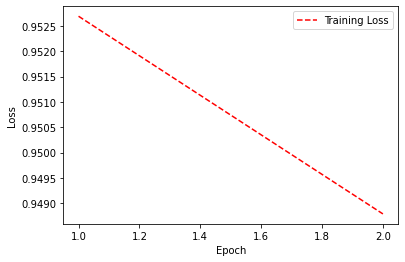

Epoch: 2 Batch: 0 Loss: 0.9439813494682312
Epoch: 2 Batch: 100 Loss: 0.9381018877029419
Epoch: 2 Loss: 0.9394276252923868 Accuracy: 0.9097538590431213


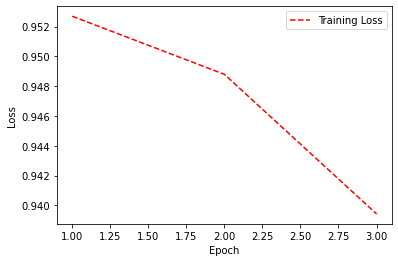

Epoch: 3 Batch: 0 Loss: 0.9260573387145996
Epoch: 3 Batch: 100 Loss: 0.8911530375480652
Epoch: 3 Loss: 0.8987639187238156 Accuracy: 0.9633328914642334


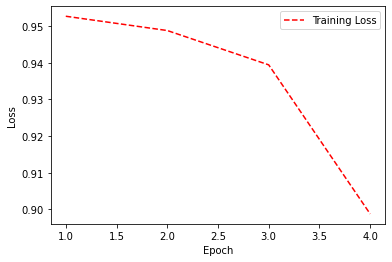

RuntimeError: [enforce fail at inline_container.cc:319] . unexpected pos 1344 vs 1288

In [30]:
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=64)

print(device)
loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)

epochs = 15000

training_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):



        ids = batch['indices'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(ids)
        #print('outputs', outputs)
        #print('labels', labels)

        preds = torch.where(outputs > 0.5, torch.ones_like(outputs), torch.zeros_like(outputs))
        #print('preds', preds)
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss.grad_fn)
        #loss.requires_grad = True
        correct_predictions += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    accuracy = correct_predictions/(len(df)*6)
    print('Epoch: {} Loss: {} Accuracy: {}'.format(e, epoch_loss, accuracy))
    plt.plot(epoch_count, training_losses, 'r--')
    # plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    torch.save(model.state_dict(), './model_save/lstm_{}.pkl'.format(e))